In [1]:
from framed.io_utils.sbml import load_cbmodel
from framed.analysis.simulation import pFBA
from framed.analysis.deletion import gene_deletion
from framed.omics.dataset import DataSet
from framed.experimental.benchmark import benchmark, run_method
from framed.experimental.fluxutils import compare_fluxes, flux_distance
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [11]:
%run '../src/gpr_mapping.py'
%run '../src/simulation.py'
%run '../src/transcriptomics.py'

## Load model and Ishii 2007 dataset

In [12]:
model = load_cbmodel('../../models/iAF1260_reduced.xml', flavor='cobra')
model_ext = transform(model, inplace=False)

dataset = DataSet('../../data/ishii2007/dataset.json')
measured_fluxes = ['R_EX_glc_e']
conditions = [cond for cond in dataset.conditions if not cond.startswith('WT_')]
ref_condition = 'WT_0.2h-1'

## Benchmark pFBA, MOMA, lMOMA and GPR variants for Ishii knockout data

In [13]:
%time result_pFBA = benchmark(run_pFBA, model, dataset, conditions=conditions, measured_fluxes=measured_fluxes)
%time result_MOMA = benchmark(run_MOMA, model, dataset, conditions=conditions, measured_fluxes=measured_fluxes, reference_condition=ref_condition)
%time result_lMOMA = benchmark(run_lMOMA, model, dataset, conditions=conditions, measured_fluxes=measured_fluxes, reference_condition=ref_condition)

error_pFBA = [x[0] for x in result_pFBA.values()]
error_MOMA = [x[0] for x in result_MOMA.values()]
error_lMOMA = [x[0] for x in result_lMOMA.values()]

CPU times: user 15.2 s, sys: 178 ms, total: 15.4 s
Wall time: 17.9 s
CPU times: user 26 s, sys: 279 ms, total: 26.3 s
Wall time: 27.8 s
CPU times: user 46.2 s, sys: 504 ms, total: 46.7 s
Wall time: 46.6 s


In [14]:
%time result_g_pFBA = benchmark(run_g_pFBA, model_ext, dataset, conditions=conditions, measured_fluxes=measured_fluxes)
%time result_g_MOMA = benchmark(run_g_MOMA, model_ext, dataset, conditions=conditions, measured_fluxes=measured_fluxes, reference_condition=ref_condition)
%time result_g_lMOMA = benchmark(run_g_lMOMA, model_ext, dataset, conditions=conditions, measured_fluxes=measured_fluxes, reference_condition=ref_condition)

error_g_pFBA = [x[0] for x in result_g_pFBA.values()]
error_g_MOMA = [x[0] for x in result_g_MOMA.values()]
error_g_lMOMA = [x[0] for x in result_g_lMOMA.values()]

CPU times: user 23.4 s, sys: 498 ms, total: 23.9 s
Wall time: 23.7 s
CPU times: user 47.2 s, sys: 710 ms, total: 47.9 s
Wall time: 47.6 s
CPU times: user 1min 3s, sys: 710 ms, total: 1min 3s
Wall time: 1min 3s


## Plot results

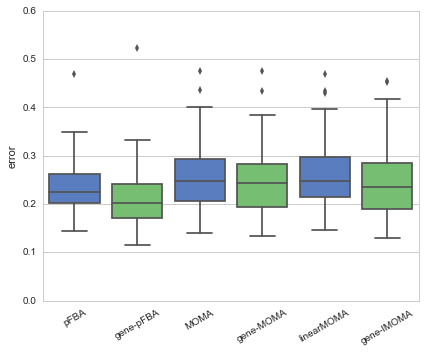

In [19]:
data = OrderedDict([('pFBA', error_pFBA),
                    ('gene-pFBA', error_g_pFBA),
                    ('MOMA', error_MOMA),
                    ('gene-MOMA', error_g_MOMA),
                    ('linearMOMA', error_lMOMA),
                    ('gene-lMOMA', error_g_lMOMA)])

plt.figure(figsize=(6,5))
ax = sns.boxplot(pd.DataFrame(data), palette=sns.color_palette("muted", n_colors=2))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30)

plt.ylim((0,0.6))
plt.ylabel('error')
plt.tight_layout()
plt.savefig('../../results/benchmark/knockouts.png', dpi=150)